In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from astropy.io import votable
import astroquery
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord, ITRS, ICRS, FK5
from astropy.table import Table
from astropy.time import Time

In [2]:
%matplotlib notebook

In [53]:
datafile = open("Table2Data.csv")

data = datafile.readlines()

datafile.close()

HDNum = []
mag = []
specs = []

for line in data:
    line = line.strip().split(',')
    #print(len(line),line[0])
    HD = line[2].split('/')
    HDNum.append(HD[0])
    mag.append(float(line[6].split('/')[0]))
    specs.append(line[8].split('/')[0])
#data = np.genfromtxt("Table2Data.csv", usecols=(2,6,8),skip_header=3,delimiter=',',dtype=str)
#print(data)
#mags = data[:,1]
#print(mags)
#name = data[:,0]
#specs = data[:,2]

SpecType = []
for i in range(len(specs)):
    
    SpecType.append(re.split("[IVpm+-/]",specs[i])[0].strip())

specplot, specindices = np.unique(SpecType,return_inverse=True) 
print(specplot)
alphabet = "OBAFGKM0123456789WNC"
SortedSpecplot = sorted(specplot, key=lambda word: [alphabet.index(c) for c in word])


['A' 'A0' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'B' 'B0' 'B1' 'B2' 'B3'
 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'F0' 'F1' 'F2' 'F3' 'F4' 'F5' 'F6' 'F7'
 'F8' 'F9' 'G0' 'G2' 'G5' 'G6' 'G7' 'G8' 'G9' 'K0' 'K1' 'K2' 'K3' 'K4'
 'K5' 'K6' 'K7' 'M1' 'M2' 'M3' 'M4' 'O4' 'O7' 'O8' 'O9' 'WN5']


In [4]:
s = Simbad()
s.add_votable_fields('ids','parallax','fluxdata(B)','fluxdata(V)','sp')
s.get_votable_fields()

SimbadList = s.query_objects(HDNum)
SimbadList.pprint()


  MAIN_ID         RA           DEC      ...   SP_TYPE   SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                             
----------- ------------- ------------- ... ----------- ----------------
  * bet Cas 00 09 10.6851 +59 08 59.212 ...       F2III                1
  * kap Cas 00 32 59.9911 +62 55 54.417 ...        B1Ia                2
  * zet Cas 00 36 58.2841 +53 53 48.867 ...        B2IV                3
  * alf Cas 00 40 30.4410 +56 32 14.392 ...     K0-IIIa                4
  * ksi Cas 00 42 03.8922 +50 30 45.120 ...         B2V                5
  * eta Cas 00 49 06.2945 +57 48 54.638 ...         F9V                6
  * gam Cas 00 56 42.5317 +60 43 00.265 ...    B0.5IVpe                7
  * phi And 01 09 30.1256 +47 14 30.459 ...      B5IIIe                8
  * tet Cas 01 11 06.1622 +55 08 59.647 ...         A7V                9
  * del Cas 01 25 48.9514 +60 14 07.022 ...        A5IV               10
        ...           ...           ... ...        

In [5]:
df = SimbadList.to_pandas()
SimbadList.columns
#df['MAIN_ID'][np.isnan(df['PLX_VALUE'])]
#print(df['RA'])

<TableColumns names=('MAIN_ID','RA','DEC','RA_PREC','DEC_PREC','COO_ERR_MAJA','COO_ERR_MINA','COO_ERR_ANGLE','COO_QUAL','COO_WAVELENGTH','COO_BIBCODE','IDS','PLX_VALUE','PLX_PREC','PLX_ERROR','PLX_QUAL','PLX_BIBCODE','FILTER_NAME_B','FLUX_B','FLUX_ERROR_B','FLUX_SYSTEM_B','FLUX_BIBCODE_B','FLUX_VAR_B','FLUX_MULT_B','FLUX_QUAL_B','FLUX_UNIT_B','FILTER_NAME_V','FLUX_V','FLUX_ERROR_V','FLUX_SYSTEM_V','FLUX_BIBCODE_V','FLUX_VAR_V','FLUX_MULT_V','FLUX_QUAL_V','FLUX_UNIT_V','SP_TYPE','SCRIPT_NUMBER_ID')>

In [6]:
# Using the Simbad data, I need to parse out the Gaia data where it's available.
#print(SimbadList)
IDS = df.IDS
GaiaList = [None]*(len(HDNum))
GaiaRelease = [None]*len(HDNum)
for i in range(0,len(IDS)):
    
    #IDS[i] = np.array(IDS[i].split('|'))
    match = re.search("Gaia(.*)",IDS[i])
    #print(match)
    if match != None:
        GaiaIDS = match.group(1)
        GaiaIDS = GaiaIDS.split('|')
        # Split this into DR2 and DR3 lists
        if len(GaiaIDS) == 1:
            GaiaList[i] = GaiaIDS[0].split()[1]
            GaiaRelease[i] = GaiaIDS[0].split()[0]
            
        elif len(GaiaIDS) > 1:
            matches = [match for match in GaiaIDS if "EDR3" in match]
            if len(matches) == 0:
                matches = [match for match in GaiaIDS if "DR2" in match]
            #print(matches, GaiaIDS)
            matches = matches[0].split()
            GaiaList[i] = matches[-1]
            GaiaRelease[i] = matches[-2]
#print(GaiaRelease,GaiaList)
#print((GaiaList[GaiaList==0.0]).size)

In [7]:
#coord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
df['GaiaParallax'] = np.nan
width = u.Quantity(0.01, u.deg)

height = u.Quantity(0.01, u.deg)

for i in range(len(HDNum)):
    coord = SkyCoord(ra=df['RA'][i],dec=df['DEC'][i], unit=(u.hourangle,u.degree),frame='icrs')

    #if GaiaRelease != None:
    r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

    #print(i, r['parallax'])
    if len(r['parallax'])>0:
        df.loc[i, 'GaiaParallax'] = r['parallax'][0]
        #r.pprint(max_lines=12)


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/clovekin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1012: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [8]:
df['FinalParallax'] = df['GaiaParallax']


In [196]:
# check to see which stars do not have Gaia Parallax
indices = np.argwhere(np.isnan(df['FinalParallax'].values))
print(df['PLX_VALUE'])
print(len(np.argwhere(np.isnan(df['GaiaParallax'].values))))
# about 60 stars are missing, so replace the nans with the Simbad (usually Hipparcos) parallax
for i in indices:
    print(i, df.loc[i[0],'PLX_VALUE'])
    df.loc[i[0],'FinalParallax'] = df.loc[i[0],'PLX_VALUE']
#print(df.GaiaParallax[df.GaiaParallax< 0])
df.FinalParallax[df.GaiaParallax<0] = df.PLX_VALUE[df.GaiaParallax<0]
#print(df.FinalParallax[df.FinalParallax< 0])

0      59.5800
1       0.7300
2       5.5000
3      14.2900
4       2.9022
        ...   
296     2.8900
297     4.1500
298     4.8857
299     0.7200
300     4.7337
Name: PLX_VALUE, Length: 301, dtype: float64
46
[81] nan
[140] nan


<ipython-input-196-3e72eee25b19>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.FinalParallax[df.GaiaParallax<0] = df.PLX_VALUE[df.GaiaParallax<0]


<IPython.core.display.Javascript object>


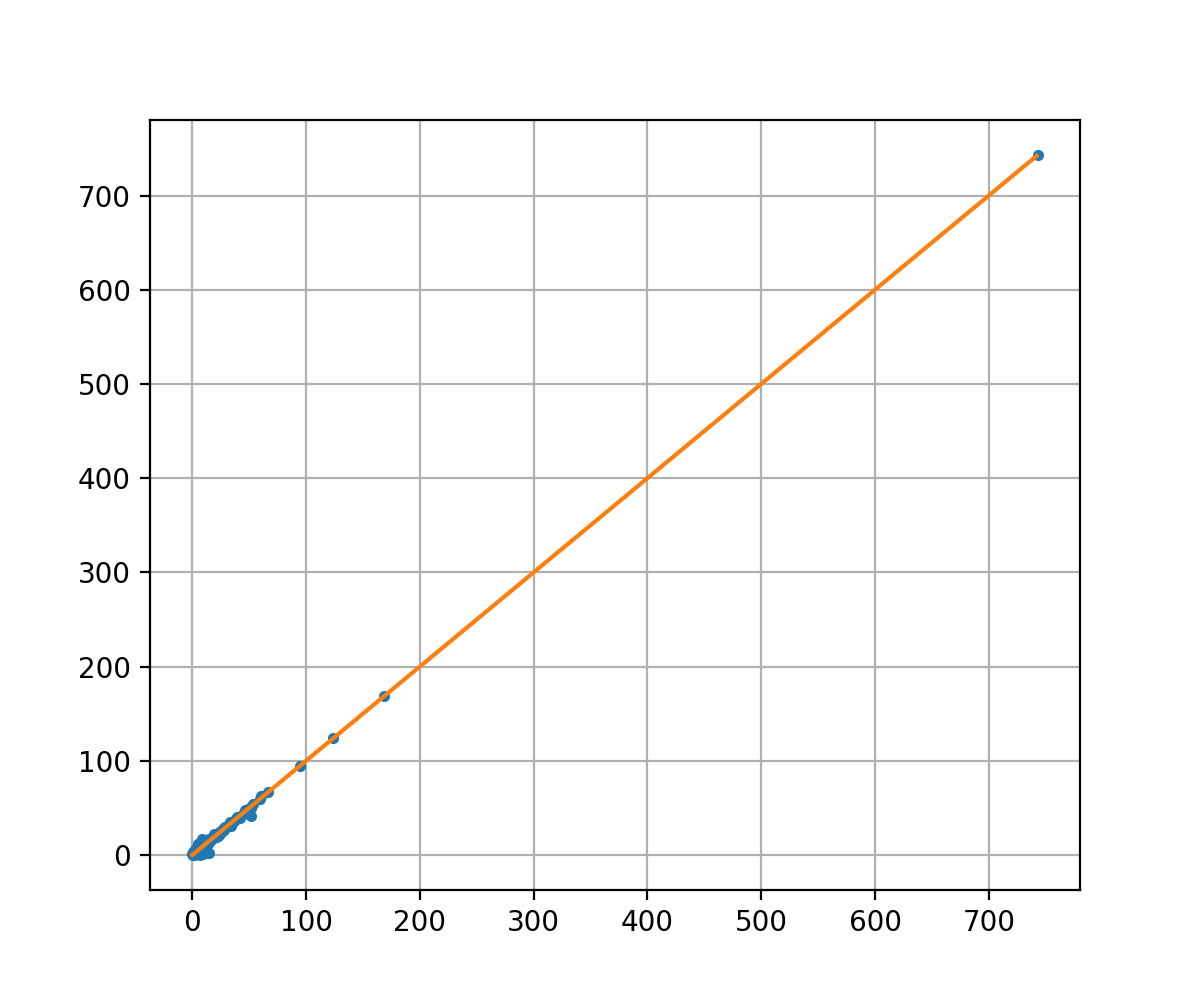

In [156]:
plt.figure(figsize=(6,5))
plt.plot(df['PLX_VALUE'],df['FinalParallax'],'.')
plt.plot(np.arange(np.max(df['PLX_VALUE'])),np.arange(np.max(df['PLX_VALUE'])))
plt.grid()
# check for parallax agreement

In [11]:
print(np.argwhere(np.isnan(df['FinalParallax'].values)))

[[ 81]
 [140]]


In [125]:
# Use extinction map (see below) to correct observed fluxes
data = np.loadtxt("Extinction.txt",skiprows=16) # A_V from Schlafly and Finkbeiner 2011 (ApJ 737, 103)
df['Extinction'] = data[:,9]
print(np.max(df.Extinction))

47.8084


In [157]:
# Get B-V from Simbad values:

df['Colour'] = df['FLUX_B'] - df['FLUX_V']

# and scale magnitudes by distance:


df['Dist'] = 1/df['FinalParallax'] * 1000
#m - M = 5 log d/10 + A
df['absMag'] = mag - 5 * np.log(df['Dist'] /10) - df['Extinction']


<IPython.core.display.Javascript object>


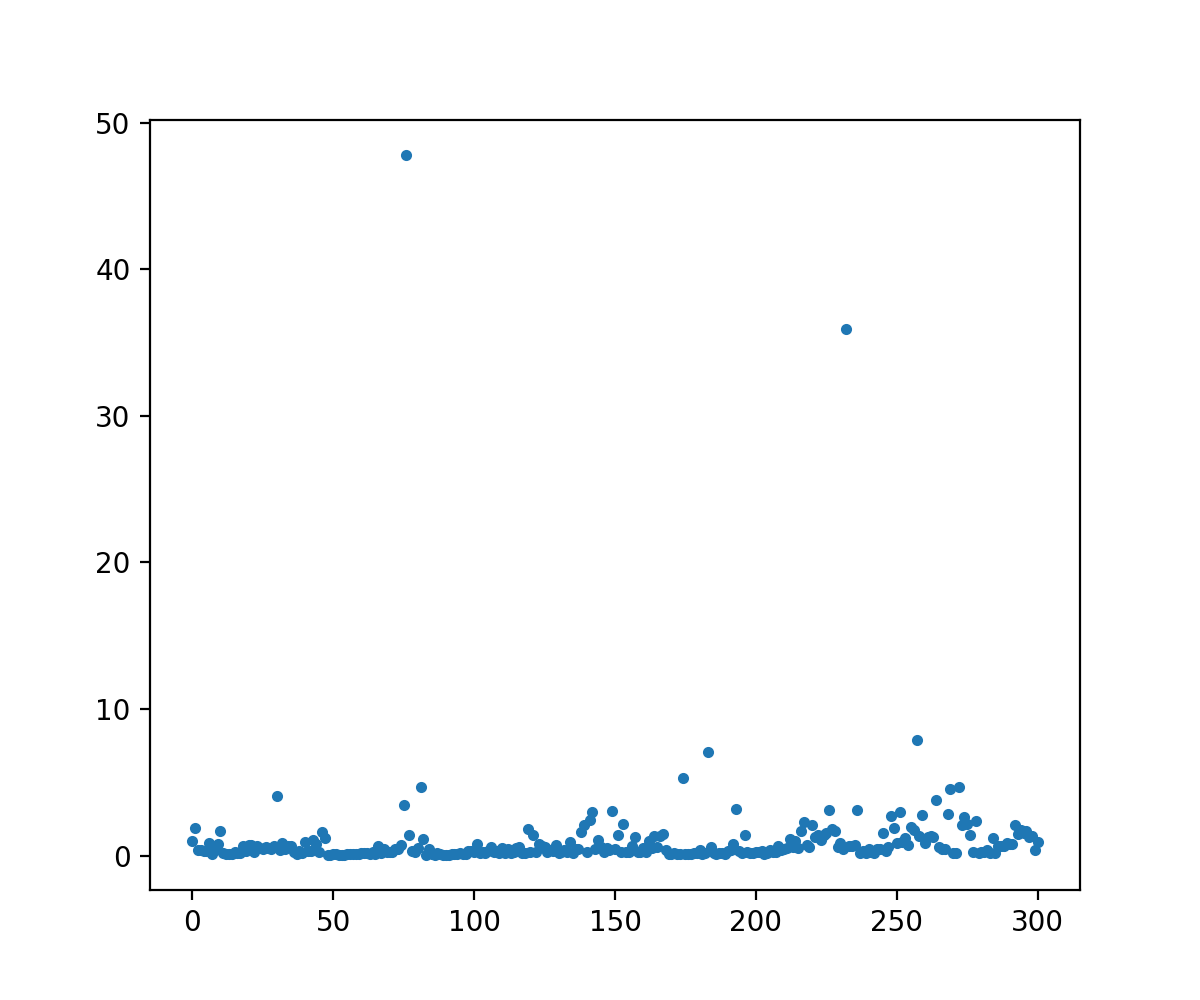

In [158]:
plt.figure(figsize=(6,5))
plt.plot(df['Extinction'],'.')

In [136]:
# Need to sort by spectral type before making the histogram
df['SpecClass'] = df['SP_TYPE'].str[0]
sorter = ['O','B','A','F','G','K','M', 'W']
sorterIndex = dict(zip(sorter, range(len(sorter))))
df['SpecType'] = df['SpecClass'].map(sorterIndex)
df.SpecType

0      3.0
1      1.0
2      1.0
3      5.0
4      1.0
      ... 
296    1.0
297    6.0
298    1.0
299    1.0
300    1.0
Name: SpecType, Length: 301, dtype: float64

In [137]:
# Write the results to a datafile so plots can be changed without redoing the queries
df.to_csv("BRITE_HRD_Data.csv")


<IPython.core.display.Javascript object>


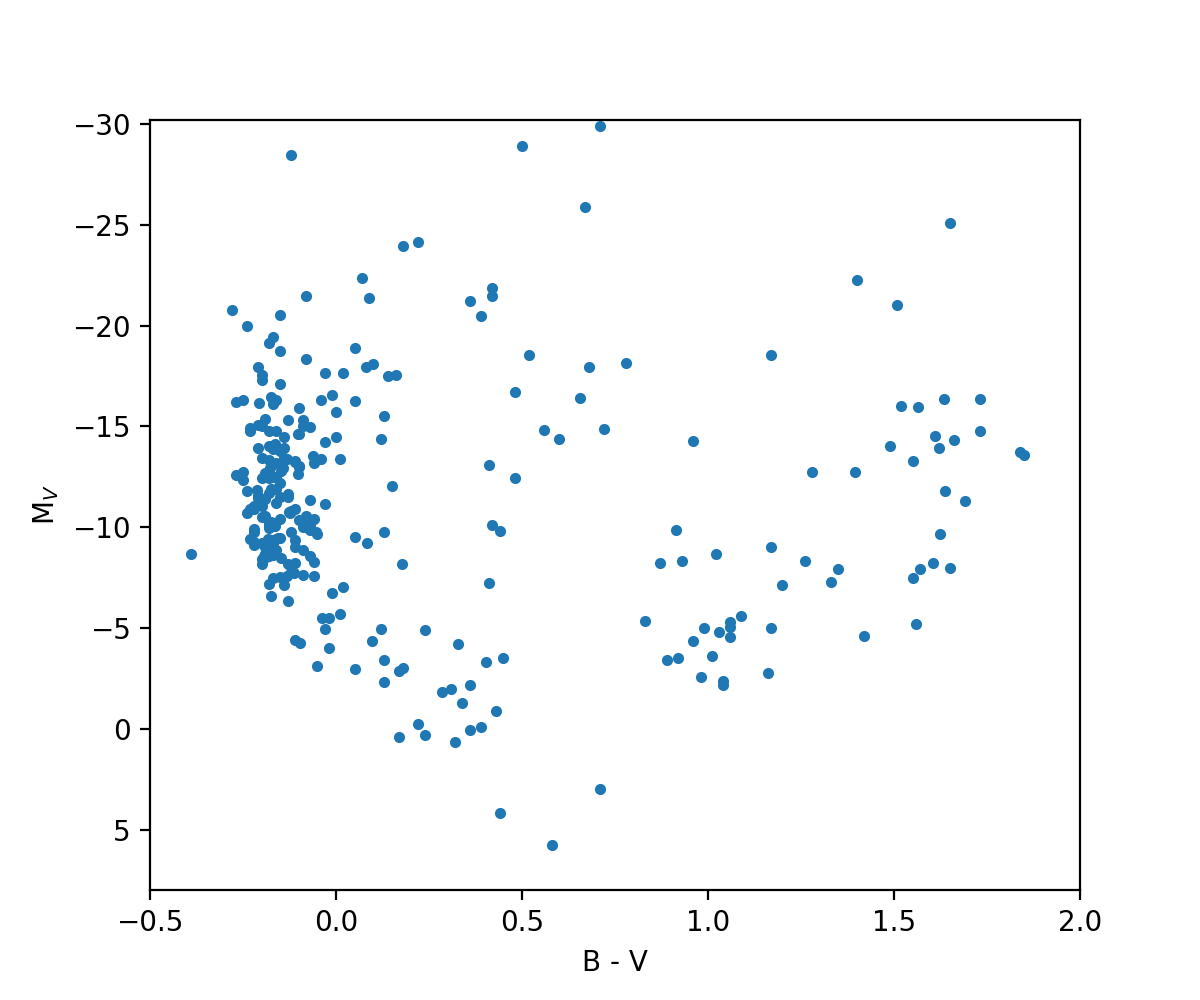

In [181]:
plt.figure(figsize=(6,5))
plt.plot(df['Colour'],df['absMag'],'.')
plt.gca().invert_yaxis()
plt.xlabel("B - V")
plt.ylabel("M$_V$")
# two stars have extremely high dust corrections, which gives them unreasonably large M_v, so I've adjusted the axis
# to exclude them
plt.axis([-0.5,2,8,-30.2])
#plt.savefig("BRITE_HRD.png")

<IPython.core.display.Javascript object>


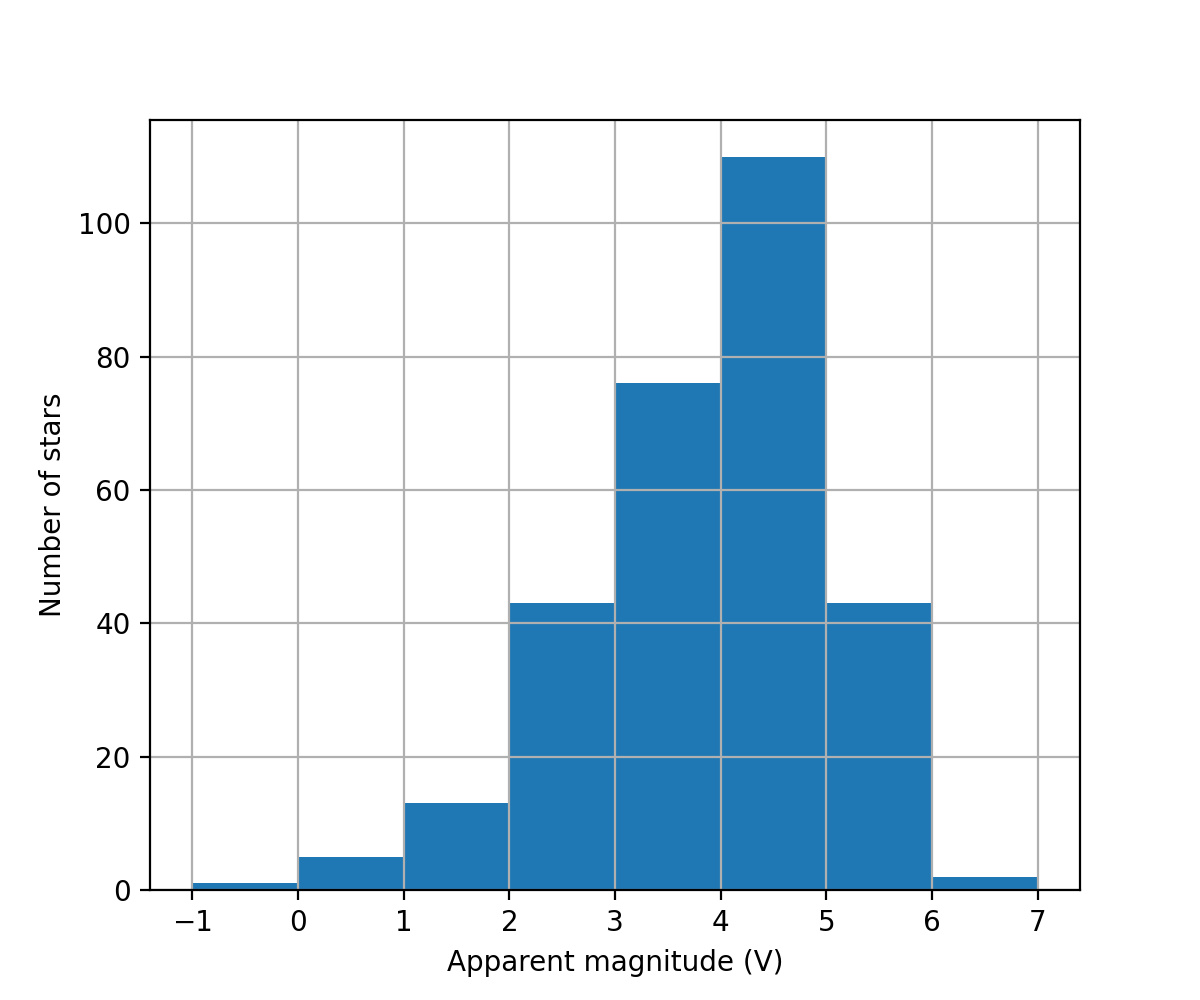

In [84]:
# make the histograms of number of stars with given magnitude and spectral type
plt.figure(figsize=(6,5))
ax = plt.gca()
df["FLUX_V"].hist(bins=[-1,0,1,2,3,4,5,6,7])
plt.xlabel("Apparent magnitude (V)")
plt.ylabel("Number of stars")
#plt.savefig("MagnitudeDistribution.png")


<IPython.core.display.Javascript object>


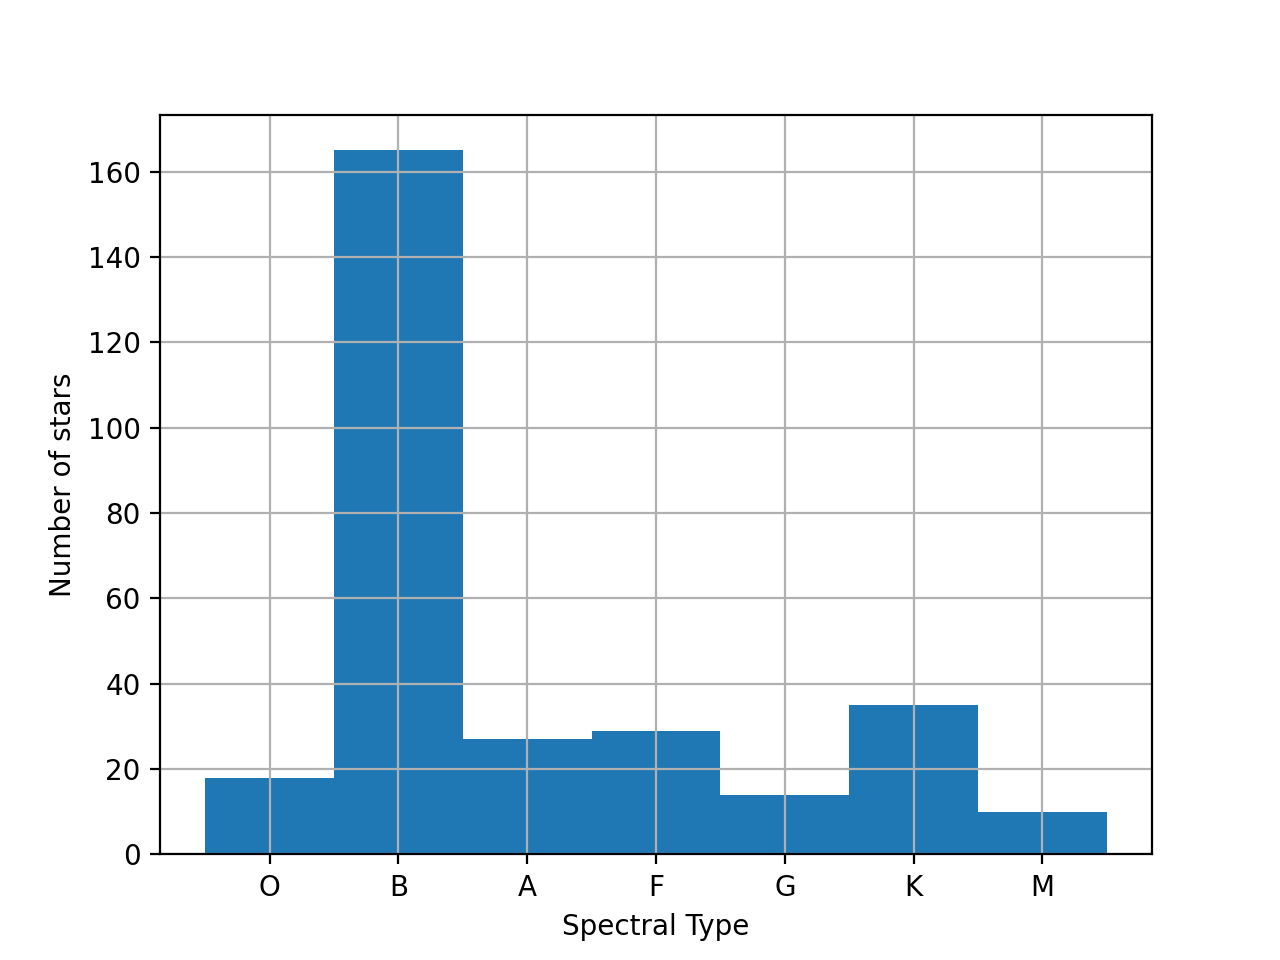

In [50]:
plt.figure()
df['SpecType'].hist(bins=7)
ind = np.unique(df.SpecType)
ax = plt.gca()
ax.set_xticks(ind[0:7] + 0.5)
ax.set_xticklabels(['O','B','A','F','G','K','M'])
plt.xlabel("Spectral Type")
plt.ylabel("Number of stars")
#plt.savefig("SpectralTypeDistribution.png")


In [99]:
# write out a file to upload to https://irsa.ipac.caltech.edu/applications/DUST/
# to get extinctions for each coordinate.
outfile = open("Positions.txt",'w')
outfile.write('ra\t dec \n')
for i in range(len(HDNum)):
    coord = SkyCoord(ra=df['RA'][i],dec=df['DEC'][i], unit=(u.hourangle,u.degree),frame='icrs')
    outfile.write(coord.to_string('decimal'))
    outfile.write('\n')

outfile.close()
#df.to_csv("Positions.txt",sep = ' ', columns=['RA','DEC'])

<IPython.core.display.Javascript object>


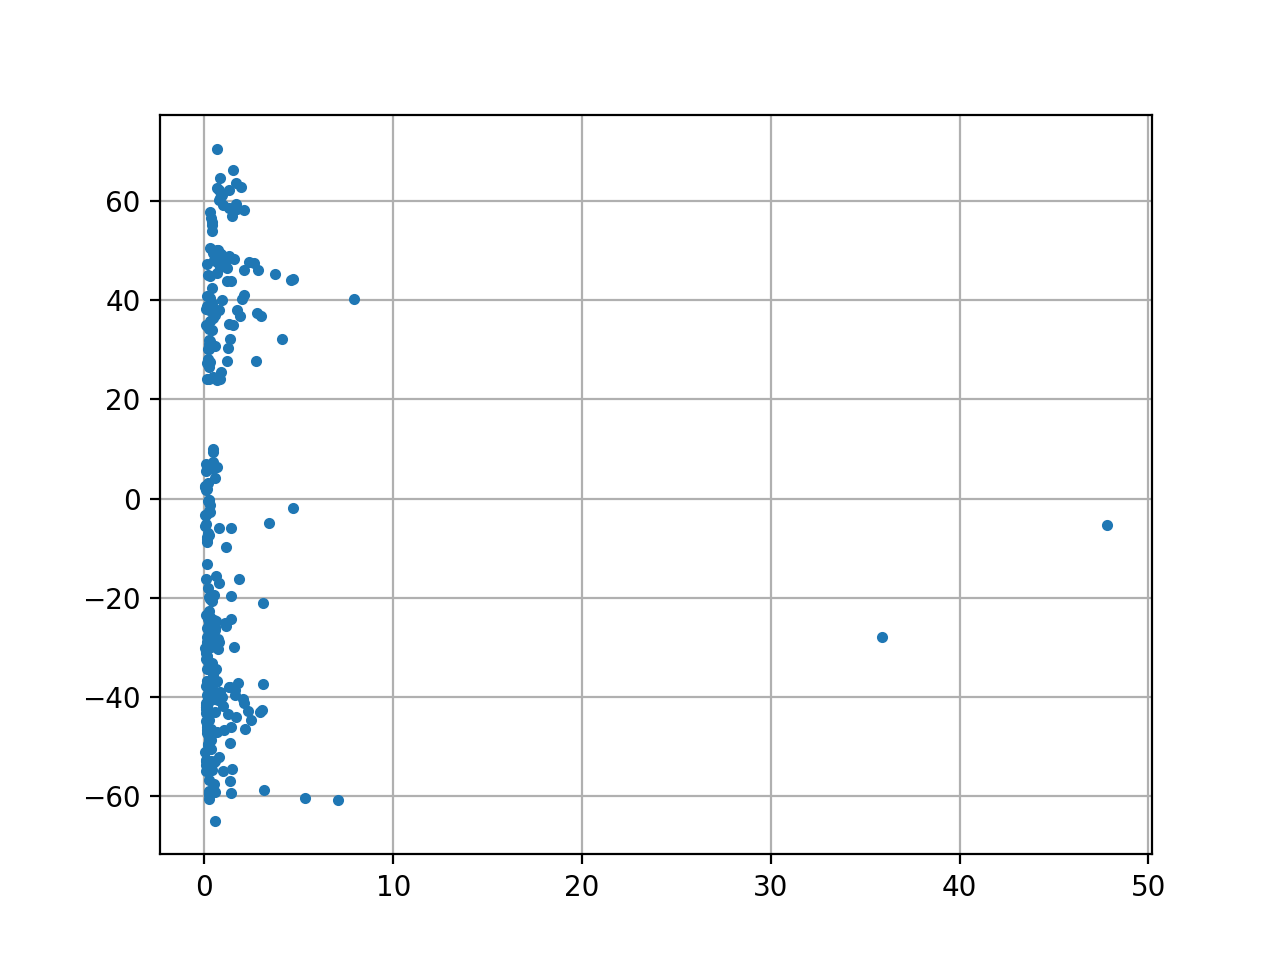

76     * tet01 Ori C
232         V* X Sgr
Name: MAIN_ID, dtype: object


In [173]:
# checking some details about extinction
coord = SkyCoord(ra = df['RA'],dec=df['DEC'],unit=(u.hourangle,u.degree),frame='icrs')
plt.figure()
plt.plot(df.Extinction,coord.dec,'.')
plt.grid()
print(df.MAIN_ID[df.Extinction > 10])

<IPython.core.display.Javascript object>


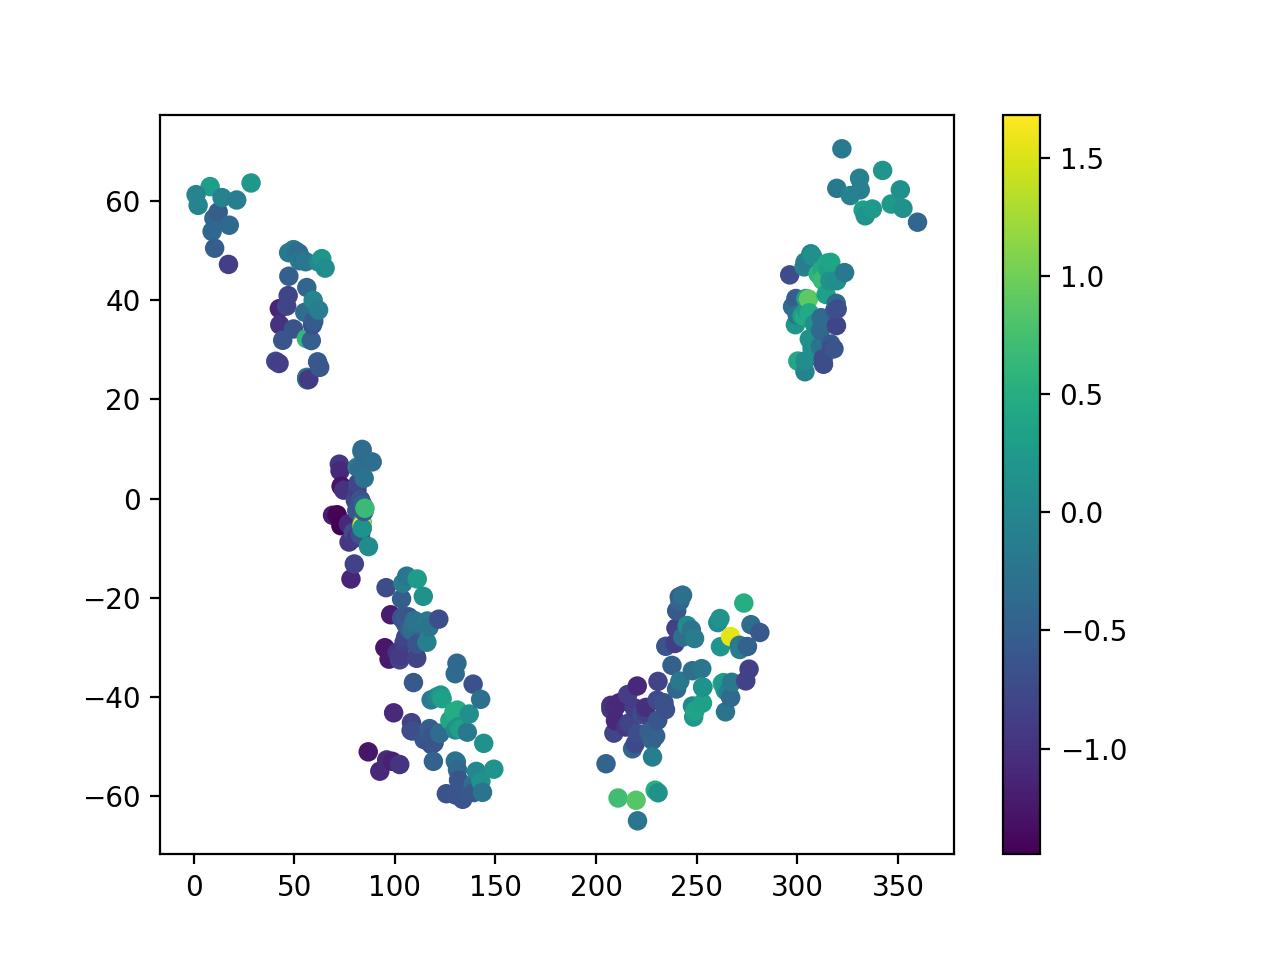

In [185]:
# check that extinction vs. position seems reasonable
plt.figure()
plt.scatter(coord.ra,coord.dec,c=np.log10(df['Extinction']))
plt.colorbar()